In [1]:
#Importing required packages.
import pandas as pd
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import re
import nltk 
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk as nlp
%matplotlib inline

In [2]:
#Load dataset
jobs = pd.read_csv('F:\\Datasets\\ML\\fake job prediction\\fake_job_postings.csv')

In [3]:
#Check how data is initially distributed
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
#Check the shape of the data
jobs.shape

(17880, 18)

In [5]:
# 0 is legitimate(not fake) and 1 is fraudulent(fake)
#Check for Imbalance
jobs['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

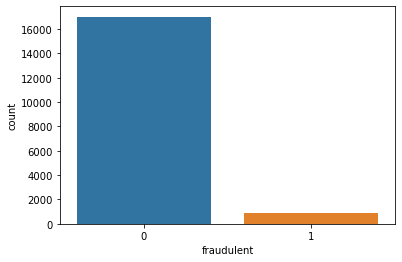

In [6]:
sns.countplot(jobs['fraudulent'])

In [7]:
#Information about the dataset
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [8]:
#Statistical analysis of the dataset
jobs.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
#Data Preprocessing

#Combine separate string type columns into one column by removing all the non-relevant features for the prediction like job_id, title, location, department, salary_range, industry and function
jobs.fillna(" ",inplace = True)
jobs['combined_text']=jobs['company_profile']+" "+jobs['description']+" "+jobs['requirements']+" "+jobs['benefits']+" "+jobs['employment_type']+" "+jobs['required_experience']+" "+jobs['required_education'] 
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,combined_text
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"We're Food52, and we've created a groundbreaki..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,"90 Seconds, the worlds Cloud Video Production ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,Valor Services provides Workforce Solutions th...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Our passion for improving quality of life thro...
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,SpotSource Solutions LLC is a Global Human Cap...


In [10]:
#Remove all the unwanted columns : non-relevant columns, columns that have combined in the previous step
drop_columns = ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
jobs_df = jobs.drop(drop_columns, axis=1)

del jobs
gc.collect()

0

In [11]:
#Check the distribution of data before the data cleaning step
jobs_df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,combined_text
0,0,1,0,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,0,Valor Services provides Workforce Solutions th...
3,0,1,0,0,Our passion for improving quality of life thro...
4,0,1,1,0,SpotSource Solutions LLC is a Global Human Cap...


In [12]:
#Cleaning data
string_list = []
for string in jobs_df.combined_text:
    string = re.sub("[^a-zA-Z]"," ",string)              #replace all expressions except a-z and A-Z with a space
    string = string.lower()                              #convert string from UPPERCASE to lowercase
    string = nltk.word_tokenize(string)                  #seperate each word in the string
    lemma = nlp.WordNetLemmatizer()                      #returns the base(lemma) form of the word
    string = [lemma.lemmatize(word) for word in string]  #breakdown every word in the string using a loop
    string = " ".join(string)                            #combine the separated words by putting a space between them again
    string_list.append(string)                           #gather all the strings into the created list 

In [13]:
# Bag of Words: 
max_features = 150                                                                    #most used 150 words in the string
count_vectorizer = CountVectorizer(max_features=max_features, stop_words = "english") #delete non-English words using stop_words
   
sparce_matrix = count_vectorizer.fit_transform(string_list).toarray()                 #fit the method on string and make a list result 

print("The most used {} words :{}".format(max_features,count_vectorizer.get_feature_names()))
X = sparce_matrix
Y = jobs_df.iloc[:,3].values 

The most used 150 words :['ability', 'able', 'account', 'agency', 'amp', 'application', 'apply', 'area', 'bachelor', 'based', 'benefit', 'best', 'brand', 'build', 'building', 'business', 'candidate', 'care', 'career', 'client', 'communication', 'company', 'competitive', 'content', 'create', 'creative', 'customer', 'data', 'day', 'degree', 'design', 'develop', 'developer', 'development', 'digital', 'drive', 'employee', 'engineering', 'ensure', 'environment', 'equivalent', 'excellent', 'experience', 'fast', 'global', 'goal', 'good', 'great', 'growing', 'growth', 'ha', 'health', 'help', 'high', 'highly', 'home', 'hour', 'include', 'including', 'individual', 'industry', 'information', 'job', 'join', 'knowledge', 'lead', 'leading', 'level', 'life', 'like', 'll', 'looking', 'love', 'make', 'manage', 'management', 'manager', 'market', 'marketing', 'medium', 'member', 'mobile', 'month', 'need', 'network', 'new', 'offer', 'office', 'online', 'operation', 'opportunity', 'organization', 'paid', '

In [14]:
#Check the distribution of data after preprocessing the data
jobs_df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,combined_text
0,0,1,0,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,0,Valor Services provides Workforce Solutions th...
3,0,1,0,0,Our passion for improving quality of life thro...
4,0,1,1,0,SpotSource Solutions LLC is a Global Human Cap...


In [15]:
#Seperating dataset for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

print('Training Features Shape : ',X_train.shape)
print('Training Labels Shape   : ',Y_train.shape)
print('Testing Features Shape  : ',X_test.shape)
print('Testing Labels Shape    : ',Y_test.shape)

Training Features Shape :  (16092, 150)
Training Labels Shape   :  (16092,)
Testing Features Shape  :  (1788, 150)
Testing Labels Shape    :  (1788,)


In [16]:
#Applying Standard scaling to get optimized result
sc = StandardScaler()

In [17]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [18]:
#Applying Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, Y_train)                   #build the classifier
pred_rfc = rfc.predict(X_test)              #predict using test data

In [19]:
#Get the accuracy score
print('Accuracy Score : ', str(accuracy_score(Y_test, pred_rfc)))

Accuracy Score :  0.977069351230425


In [20]:
#Check model performance
print(classification_report(Y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1693
           1       1.00      0.57      0.72        95

    accuracy                           0.98      1788
   macro avg       0.99      0.78      0.86      1788
weighted avg       0.98      0.98      0.97      1788



In [21]:
#Confusion matrix for the random forest classification
print(confusion_matrix(Y_test, pred_rfc))

[[1693    0]
 [  41   54]]


In [22]:
#Cross Validation Score for random forest

#Evaluation for random forest model using cross validation.
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = Y_train, cv = 10)
rfc_eval.mean()

0.9751430038332517